## Mapping Northern Sea Otter habitats and Create Story 🦦🌊

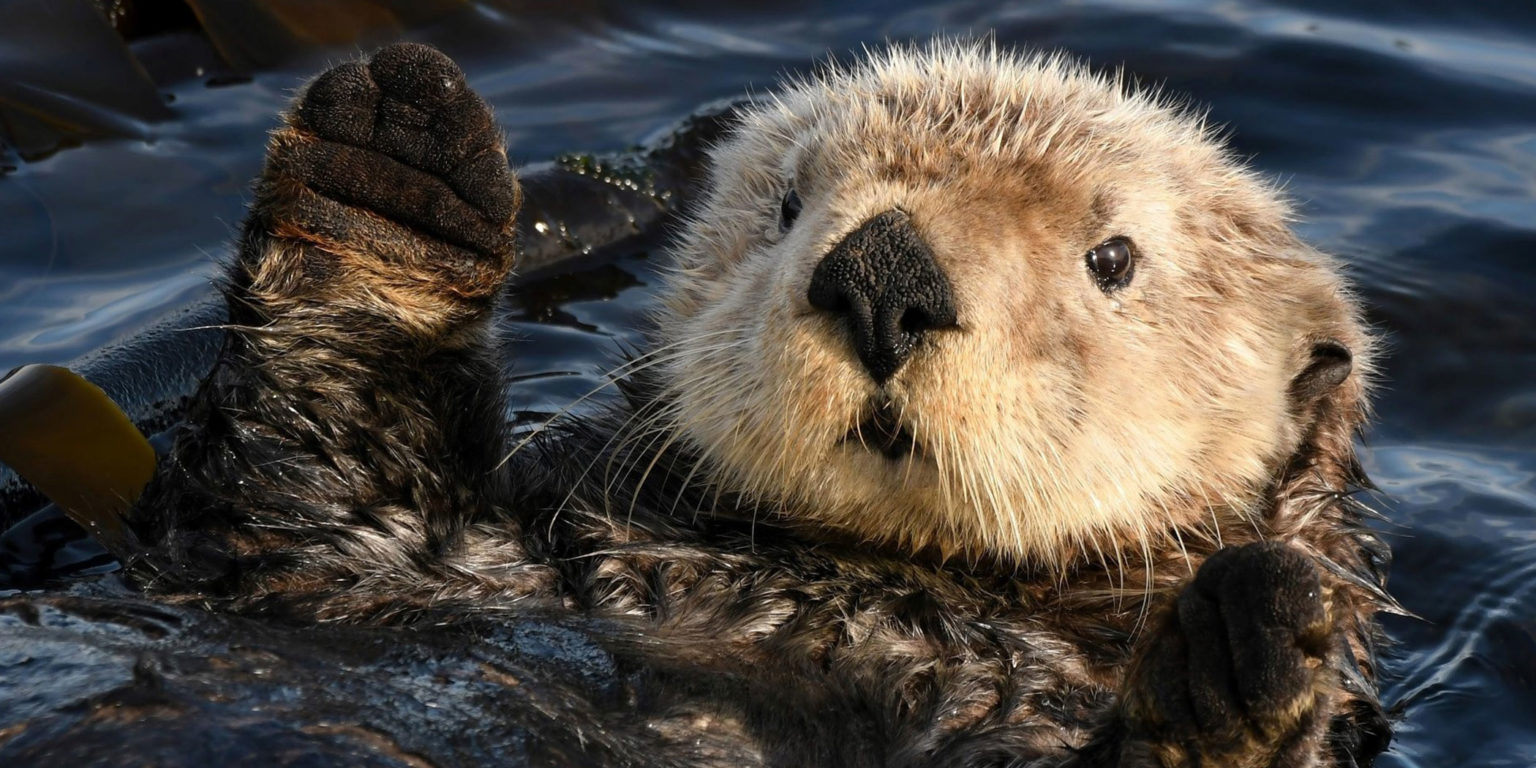

### Overview

 - Story: 
     - Map out the habitat for Northern Sea Otter in North Pacific Ocean (around Alaska)
     - Map out the Exxon Valdez oil spill affected habitat area
         - The greatest threat to the sea otter population is an oil spill. Oil ruins the insulating property of an otter's fur
     - create a StoryMap and Briefing with illustration of the map (functionality released in Python API v2.3)
 - Data
     - Critical Habitat for Threatened and Endangered Species
         - from National Geospatial Data Asset (NGDA) dataset, Living Atlas
     - EVOS Boundary
         - Exxon Valdez Oil Spill polygon area
         - from Alaska Department of Natural Resources ArcGIS Online
 - In this Notebook, we will utilize the functionalities within these following modules:
     - `features`
         - Access `Feature Layer`, query `Features`, usage of `Spatial Enabled DataFrame`, and feature analysis tools
     - `mapping`
         - Create `WebMap` for Sea Otter habitat and overlay_layers and save it to ArcGIS Online as an WebMap Item
     - `apps`
         - Create `StoryMap` and embed WebMap Item
         - Create `Briefing` for the WebMap

### 0. Connect to your ArcGIS Online and get the data item

In [6]:
from arcgis.gis import GIS
gis = GIS("home")

### 1. Working with Feature Layer Collection, Feature Layers and Spatially Enabled DataFrame (feature module)

- Workflow
    - a. access a Feauture Layer from habitat polygon FLC Item, and query Features as FeatureSet using SQL statement
        - `FeatureLayerCollection.layers[0]`
        - `FeatureLayer.query()`
    - b. access Map Feature Layer from Exxon Valdez oil spill area Item
    - c. convert FeatureSet to Spatially enabled DataFrame
        - `FeatureSet.sdf`

##### a. get data from ArcGIS Online and access Feature Layers

In [7]:
from arcgis.features import GeoAccessor # for SeDf
from arcgis.features import FeatureLayer

<Item title:"Critical Habitat for Threatened and Endangered Species" type:Feature Layer Collection owner:Esri_US_Federal_Data>
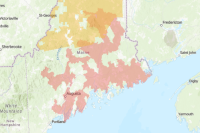

In [8]:
habitat = gis.content.get("9d0965dae6a64f38b1af80c2f7ea2efe")
habitat

<Item title:"EVOS Boundary" type:Map Image Layer owner:irm_admin>
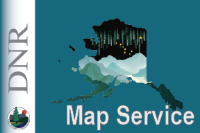

In [9]:
evos = gis.content.get("2772df22ae864e3a9faa5c8de2c5bed3")
evos

In [10]:
evos_fl = evos.layers[0]
evos_fl

<MapFeatureLayer url:"https://arcgis.dnr.alaska.gov/arcgis/rest/services/OpenData/NaturalResource_EVOSBoundary/MapServer/0">

In [11]:
habitat_fl = habitat.layers[0]
habitat_fl

<FeatureLayer url:"https://services.arcgis.com/QVENGdaPbd4LUkLV/arcgis/rest/services/USFWS_Critical_Habitat/FeatureServer/0">

##### b. query Northern Sea Otter habitats and specify output fields, and get spatially enabled dataframe from FeatureSet

In [12]:
# all habitats for Northern Sea Otter filtered with specific fields
otter_habitat_fs = habitat_fl.query(
    where="comname like 'Northern Sea Otter'", 
    out_fields=["OBJECTID", "comname", "pubdate", "listing_status", "Shape__Area"]
)
otter_habitat_fs

<FeatureSet> 1 features

In [13]:
otter_habitat_df = otter_habitat_fs.sdf
type(otter_habitat_df)

pandas.core.frame.DataFrame

In [14]:
otter_habitat_df

,OBJECTID,comname,pubdate,listing_status,Shape__Area,SHAPE
0,403,Northern Sea Otter,20091008,Threatened,48813112102.4375,"{""rings"": [[[-17141349.1227555, 8264704.071509..."


### 2. Working with Map Widgets (mapping module, feature module)

 - create Map Widget (MapView object): `gis.map()`
 - map the above Feature Layer: `MapView.add_layers()`
 - map the above Spatially Enabled DataFrame: `df.spatial.plot(MapView)`
 - save Map Widget to WebMap object in ArcGIS Online: `MapView.save()`
 - perform Feature Analysis based on two layers
     - `overlay_layers()`: create new Feature Layer to display the Northern Sea Otter habitat that was affected by Exxon Valdez Oil Spill

##### a. Create habitat web map and save to AGOL

In [15]:
# map sedf
otter_habitat_map = gis.map('Alaska')

In [16]:
otter_habitat_map.zoom = 2

In [17]:
otter_habitat_df.spatial.plot(map_widget=otter_habitat_map)

True

In [18]:
otter_habitat_map

Map(center=[9558001.620612685, -16809705.955632918], extent={'xmin': -18909636.829957232, 'ymin': 5771393.7893…

In [19]:
# add map widget as a web map on online portal
otter_habitat_map_properties = {'title':'sea otter habitat web map',
                                'snippet': 'sea otter habitat web map saved from uc2024 notebook',
                                'tags':['uc2024'],
                                'extent': otter_habitat_map.extent}

otter_habitat_map_saved = otter_habitat_map.save(otter_habitat_map_properties)
otter_habitat_map_saved

<Item title:"sea otter habitat web map" type:Web Map owner:ssong_geosaurus>

##### b. Perform feature analysis `overlay_layers`, add this analysis layer to map, and create affected habitat web map

In [20]:
# add layer
otter_habitat_map.content.add(evos_fl)

In [ ]:
# create overlap layer and save as a hosting feature layer in ArcGIS Online
# take several minutes
from arcgis.features import manage_data
overlap = manage_data.overlay_layers(input_layer=otter_habitat_map.content.layers[1], 
                                     overlay_layer=otter_habitat_map.content.layers[0],
                                     overlay_type="Intersect",
                                     output_name="overlay_habitat_evos")

<Item title:"overlay_layer_evos_and_seaotter_habitat" type:Feature Layer Collection owner:ssong_geosaurus>
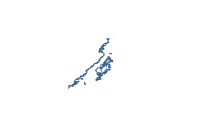

In [21]:
affected_habitat_agol = gis.content.search("title: overlay_layer_evos_and_seaotter_habitat AND owner:ssong_geosaurus", item_type="Feature Layer")[0]
affected_habitat_agol

In [22]:
otter_habitat_map.content.add(affected_habitat_agol)

In [23]:
otter_habitat_map.content.layers

[<FeatureCollection>,
 <MapFeatureLayer url:"https://arcgis.dnr.alaska.gov/arcgis/rest/services/OpenData/NaturalResource_EVOSBoundary/MapServer/0">,
 <FeatureLayer url:"https://services7.arcgis.com/JEwYeAy2cc8qOe3o/arcgis/rest/services/overlay_layer_test_ss_1/FeatureServer/0">]

In [24]:
# remove layer that will not use
otter_habitat_map.content.remove(1)

True

In [25]:
otter_habitat_map.content.layers

[<FeatureCollection>,
 <FeatureLayer url:"https://services7.arcgis.com/JEwYeAy2cc8qOe3o/arcgis/rest/services/overlay_layer_test_ss_1/FeatureServer/0">]

In [26]:
affected_habitat_webmap_properties = {'title':'sea otter habitat, and affected area by EVOS web map',
                                      'snippet': 'sea otter habitat area affected by Exxon Valdez web nap saved from uc2024 notebook',
                                      'tags':['uc2024'],
                                      'extent': otter_habitat_map.extent}

affected_habitat_webmap_saved = otter_habitat_map.save(item_properties=affected_habitat_webmap_properties)
affected_habitat_webmap_saved

<Item title:"sea otter habitat, and affected area by EVOS web map" type:Web Map owner:ssong_geosaurus>

### 3. Work with StoryMap (apps module)

- Workflow:
    - create StoryMap: `StoryMap()`
    - create StoryMap Briefing: `Briefing()`

In [27]:
from arcgis.apps.storymap import StoryMap, Briefing, Image, Text, Map

##### a. Get habitat WebMap Item and affected area Feature Layer Item from AGOL

In [28]:
habitat_map_agol = gis.content.search("title:sea otter habitat web map AND owner:ssong_geosaurus", item_type="Web Map")[0]
habitat_map_agol

<Item title:"sea otter habitat, and affected area by EVOS web map" type:Web Map owner:ssong_geosaurus>

In [29]:
affected_habitat_map_agol = gis.content.search("title: sea otter habitat area affected by Exxon Valdez web map AND owner:ssong_geosaurus", item_type="Web Map")[0]
affected_habitat_map_agol

<Item title:"sea otter habitat, and affected area by EVOS web map" type:Web Map owner:ssong_geosaurus>

##### c. Get prepared for the contents:
 - use `Image`, `Text`, `Map` classes from apps module to initialize contents

In [27]:
image1 = Image(r'C:\Users\shu12142\Documents\2024UC\sea otter.jpg')
image1.caption = "Sea otters in glacier ice, northern Prince William Sound, Alaska. (Patrick J. Endres / AlaskaPhotoGraphics.com)"

image2 = Image(r'C:\Users\shu12142\Documents\2024UC\sea otter swim.jpg')
image2.caption = "Sea otter, Port Wells, Prince William Sound, Alaska. (Patrick J. Endres / AlaskaPhotoGraphics.com)"

text_description = Text(r"[intro] Sea otters are members of the weasel family (Mustelidae) and are related to mink and river otters. Adult males weigh 70 to 90 pounds (32-41 kg), and females average 40 to 60 pounds (18-27 kg). The fur consists of a dense underfur of inch-long fibers and sparse guard hairs. Sea otters depend on air trapped in their fur to maintain body temperature. If the fur becomes soiled or matted by a material such as oil, the insulation qualities are lost.")

text_habitat = Text(r"[habitats] The sea otter lives in shallow water areas along the shores of the North Pacific. Its range once extended from southern California north then west through the Aleutian Islands, to the Kamchatka Peninsula, and south to the northern islands of Japan. ")

text_EVOS = Text(r"[EVOS] Sea otters in the path of the oil incurred heavy mortality when 42 million liters of Prudhoe Bay crude oil were spilled in Prince William Sound in March 1989, with an estimated loss of several thousand otters. Through long-term data collection and analysis, scientists found that sea otters were slow to recover, likely because of chronic exposure to lingering oil.")

webmap1 = Map(habitat_map_agol)

webmap2 = Map(affected_habitat_map_agol)

##### c. StoryMap

 - Story Map
      - is a stand-alone resource thoughtfully created, given context, and provided with supporting information
      - integrates maps, text, photos, and video
      - Blog view
      - Python API can help you create and edit your ArcGIS Story Maps
 - Workflow:
      - create StoryMap: `StoryMap()`
      - edit StoryMap
          - add cover, text, image, map to StoryMap: `StoryMap.add()`
          - list all contents in StroyMap: `StoryMap.content_list`
      - save StoryMap: `StoryMap.save()`

In [28]:
habitat_storymap = StoryMap()

In [29]:
storymap_cover = habitat_storymap.cover(title="The Sea Otter: A threatened species in North Pacific Ocean",
                                        type="minimal",
                                        summary="Map the habitat for Sea Otter",
                                        by_line="ssong_geosaurus", 
                                        image=image1)
storymap_cover

True

In [ ]:
habitat_storymap.add(image2, caption="Sea otter, Port Wells, Prince William Sound, Alaska. (Patrick J. Endres / AlaskaPhotoGraphics.com)")
habitat_storymap.add(text_description)
habitat_storymap.add(text_habitat)
habitat_storymap.add(webmap1, caption="Sea Otter Habitat Web Map")
habitat_storymap.add(text_EVOS)
habitat_storymap.add(webmap2, caption="Sea Otter Habitat affected by EVOS Web Map")
habitat_storymap.credits("Thanks for attending the tech session!", "And please protect sea otter habitats!")

In [31]:
habitat_storymap.content_list

['Storycover',
 'Navigation',
 Image: Sea otter, Port Wells, Prince William Sound, Alaska. (Patrick J. Endres / AlaskaPhotoGraphics.com),
 Text: paragraph,
 Text: paragraph,
 Web Map,
 Text: paragraph,
 Web Map,
 'Credits']

In [32]:
habitat_storymap.content_list[5].set_viewpoint(otter_habitat_map.extent)
habitat_storymap.content_list[7].set_viewpoint(otter_habitat_map.extent)

{'rotation': 0.0,
 'scale': -1.0,
 'targetGeometry': {'spatialReference': {'latestWkid': 3857, 'wkid': 102100},
  'x': -18122365.014016744,
  'y': 7669423.4431732735}}

<Item title:"Sea Otter Habitat StoryMap" type:StoryMap owner:ssong_geosaurus>
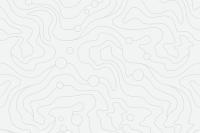

In [33]:
habitat_storymap.save(title="Sea Otter Habitat StoryMap", tags=["python", "storymap"])

##### d. StoryMap Briefing

 - Briefing
      - A slide-based presentation style type of ArcGIS StoryMap
      - Slides view.
      - Python API can help you create and edit your ArcGIS StoryMaps Briefings.
 - Workflow
      - create Briefing: `Briefing()`
      - edit Briefing
           - add cover, slides (including text, image, map) to Briefing: `Briefing.add()`
           - list all contents in Briefing: `Briefing.content_list`
      - save Briefing: `Briefing.save()`

In [34]:
habitat_briefing = Briefing()

In [35]:
briefing_cover = habitat_briefing.cover(title="The Sea Otter: A threatened species in North Pacific Ocean",
                                        type="full",
                                        summary="Map the habitat for Sea Otter",
                                        by_line="ssong_geosaurus",
                                        media=image1)
briefing_cover

True

In [36]:
briefing_slide1 = habitat_briefing.add(layout="double", title="Cute Sea Otters")

block_image = briefing_slide1.blocks[0]
block_image.add_content(image2)

block_text = briefing_slide1.blocks[1]
block_text.add_content(text_description)

Text: paragraph

In [37]:
briefing_slide2 = habitat_briefing.add(layout="double", title="Sea Otter Habitat")

block_map = briefing_slide2.blocks[0]
block_map.add_content(webmap1)

block_text = briefing_slide2.blocks[1]
block_text.add_content(text_habitat)

Text: paragraph

In [38]:
briefing_slide3 = habitat_briefing.add(layout="double", title="Sea Otter Habitat affected by EVOS")

block_map = briefing_slide3.blocks[0]
block_map.add_content(webmap2)

block_map = briefing_slide3.blocks[1]
block_map.add_content(text_EVOS)

Text: paragraph

In [39]:
briefing_slide2.blocks[0].content[0].set_viewpoint(otter_habitat_map.extent)
briefing_slide3.blocks[0].content[0].set_viewpoint(otter_habitat_map.extent)

{'rotation': 0.0,
 'scale': -1.0,
 'targetGeometry': {'spatialReference': {'latestWkid': 3857, 'wkid': 102100},
  'x': -18122365.014016744,
  'y': 7669423.4431732735}}

<Item title:"Sea Otter Habitat StoryMap Briefing" type:StoryMap owner:ssong_geosaurus>
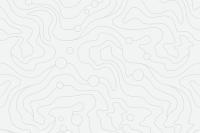

In [40]:
habitat_briefing.save(title="Sea Otter Habitat StoryMap Briefing", tags=["python", "storymap"])

#### Resources

- images and contents are from: https://www.alaskaphotographics.com/alaska-photo-articles/sea-otter-photos/
- EVOS study: 2013 Update on Sea Otter Studies to Assess Recovery from the 1989 Exxon Valdez Oil Spill, Prince William Sound, Alaska, By B.E. Ballachey, D.H. Monson, G.G. Esslinger, K. Kloecker, J. Bodkin, L. Bowen, and A.K. Miles

#### After running notebook

In [ ]:
habitat_map_agol.delete()
affected_habitat_map_agol.delete()
habitat_storymap.delete_story()
habitat_briefing.delete_briefing()